Функции forward propagation:

1-ый слой : $$ Z_1 = X\cdot {W_1}^{T} + b_1 $$
$$A_1 = f(Z_1)$$

2-ой слой : $$ Z_2 = A_1\cdot {W_2}^{T} + b_2 $$
$$A_2 = f(Z_2)$$

3-ий слой : $$ Z_3 = A_2\cdot {W_3}^{T} + b_3 $$
$$A_3 = f(Z_3)$$

4-ый слой : $$ Z_4 = A_3\cdot {W_4}^{T} + b_4 $$
$$\hat y = f(Z_4)$$


Функции back propagation:

4-ый слой: $$dZ_4 = dL * A_4*(E - A_4)$$
$$dW_4 = dL^{T} ⋅ A_3$$
$$db_4 = dL^{T} ⋅ E$$

3-ий слой: $$dZ_3 = dZ_4 ⋅ W_4 * \frac{∂A_3}{∂Z_3}$$
$$dW_3 = dZ_3^{T} ⋅ A_2$$
$$db_3 = dZ_3^{T} ⋅ E$$

2-ой слой: $$dZ_2 = dZ_3 ⋅ W_3 * \frac{∂A_2}{∂Z_2}$$
$$dW_2 = dZ_2^{T} ⋅ A_1$$
$$db_2 = dZ_2^{T} ⋅ E$$

1-ый слой: $$dZ_1 = dZ_2 ⋅ W_2 * \frac{∂A_1}{∂Z_1}$$
$$dW_1 = dZ_1^{T} ⋅ X$$
$$db_1 = dZ_1^{T} ⋅ E$$

Загрузка библиотек

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import os

Работа с датасетом

In [3]:
def load_planar_dataset(m=400):
    np.random.seed(1)
    N = int(m/2)
    D = 2 
    X = np.zeros((m,D))
    Y = np.zeros((m,1), dtype='uint8')
    a = 4

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2
        r = a*np.sin(4*t) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

In [4]:
def plot_decision_boundary(model, X, y):
    X = X.T
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

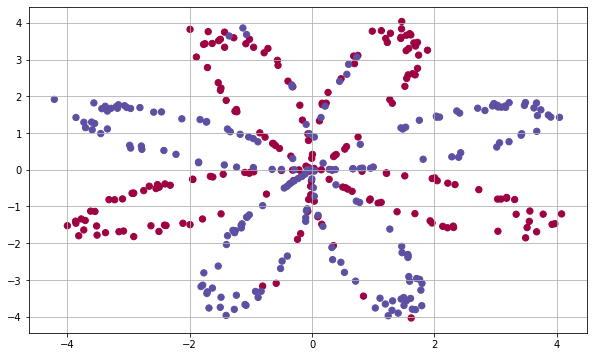

In [5]:
X, Y = load_planar_dataset()
plt.figure(figsize=(10,6))
plt.grid()
plt.scatter(X[:,0], X[:,1], c=Y[:,0], s=40, cmap=plt.cm.Spectral);

Построение модели

In [21]:
class ThreeLayers:
    def __init__(self, layers_info):
        self.params = {
                            "w1": None,
                            "w2": None,
                            "w3": None,
                            "w4": None,
                            "b1": None,
                            "b2": None,
                            "b3": None,
                            "b4": None
        }
        
        self.gradients = {
                            "dw1": None,
                            "dw2": None,
                            "dw3": None,
                            "dw4": None,
                            "db1": None,
                            "db2": None,
                            "db3": None,
                            "db4": None,
                            "dz1": None,
                            "dz2": None,
                            "dz3": None,
                            "dz4": None
        }
        
        self.cache = {
                            "z1": None,
                            "a1": None,
                            "z2": None,
                            "a2": None,
                            "z3": None,
                            "a3": None,
                            "z4": None,
                            "a4": None,
                            "X": None
        }
        
        self._initialize_params(list(layers_info.values()))
        self._initialize_activations(list(layers_info.values()))
        
    
    def _initialize_params(self, layers_info):
        layers_info.append([1])
        keys = list(self.params.keys())


        for layer in range(4):
            self.params[keys[layer]] = np.random.randn(layers_info[layer + 1][0], layers_info[layer][0])
            self.params[keys[layer + 4]] = np.zeros(layers_info[layer + 1][0],)
        
        for key in self.params.keys():
            self.gradients[key] = np.zeros_like(self.params[key])
            
    
    def _initialize_activations(self, layers_info):
        activation_functions = []
        for layer, _ in enumerate(layers_info):
            activation_functions.append(layers_info[layer][1])
        for i,activation in enumerate(activation_functions):
            if activation == "tanh":
                self.__dict__['activation'+str(i+1)] = np.tanh
                self.__dict__['activation'+str(i+1)+"_backward"] = \
                lambda x: 1 - np.tanh(x)**2
            if activation == "sigmoid":
                self.__dict__['activation'+str(i+1)] = self.sigmoid
                self.__dict__['activation'+str(i+1)+"_backward"] = \
                lambda x: self.sigmoid(x)*(1.-self.sigmoid(x))
        

    @staticmethod
    def sigmoid(z):
        return np.where(
            z >= 0,
            1 / (1 + np.exp(-z)), 
            np.exp(z) / (1 + np.exp(z))
        )

    def collect_cache(self, **kwargs):
        for key in kwargs.keys():
            self.cache[key] = kwargs[key]
            
    def collect_grads(self, **kwargs):
        for key in kwargs.keys():
            self.gradients[key] = kwargs[key]
    
    def unpack_cache(self, keys):
        output = []
        for key in keys:
            output.append(self.cache[key])
        output = tuple(output)
        return output
    

    def forward(self, X):

        z1 =X @ self.params['w1'].T + self.params['b1']
        a1 = self.activation1(z1)
        
        z2 = a1 @ self.params['w2'].T + self.params['b2']
        a2 = self.activation2(z2)

        z3 = a2 @ self.params['w3'].T + self.params['b3']
        a3 = self.activation2(z3)

        z4 = a3 @ self.params['w4'].T + self.params['b4']
        a4 = self.activation2(z4)
        
        self.collect_cache(z1=z1, z2=z2, z3=z3, z4=z4, a1=a1, a2=a2, a3=a3, a4=a4, X=X)

        return a4
    
    def __call__(self, X):
        return self.forward(X)

    def backward(self, dL):
        
        z1, a1, z2, a2, z3, a3, z4, a4, X = self.unpack_cache(['z1', 'a1', 'z2', 
                                               'a2', 'z3', 'a3', 'z4', 'a4', 'X'])

        dz4 = dL * (a4*(1. - a4))
        dw4 = dL.T @ a3
        db4 = dL.T @ np.ones((z4.shape[0]))

        dz3 = (dz4 @ self.params['w4'])*self.activation4_backward(z3)
        dw3 = (dz3.T @ a2)
        db3 = dz3.T @ np.ones(z3.shape[0])

        dz2 = (dz3 @ self.params['w3'])*self.activation3_backward(z2)
        dw2 = (dz2.T @ a1)
        db2 = dz2.T @ np.ones(z2.shape[0])
        
        dz1 = (dz2 @ self.params['w2'])*self.activation2_backward(z1)
        dw1 = (dz1.T @ X)
        db1 = dz1.T @ np.ones(X.shape[0])

        self.collect_grads(dw4=dw4, dw3=dw3, dw2=dw2, dw1=dw1, db4=db4, db3=db3, db2=db2, db1=db1)

Оптимизатор Adam

In [34]:
class AdamOptimizier:
    def __init__(self, regression_class, lr=1e-2, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, t = 2):
        self.model = regression_class
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = t

        n_layers = len(self.model.params) // 2
        v = {}
        s = {}

        for n in range(n_layers):
            v["dw" + str(n+1)] = np.zeros((self.model.params["w" + str(n+1)]).shape)
            v["db" + str(n+1)] = np.zeros((self.model.params["b" + str(n+1)]).shape)
            s["dw" + str(n+1)] = np.zeros((self.model.params["w" + str(n+1)]).shape)
            s["db" + str(n+1)] = np.zeros((self.model.params["b" + str(n+1)]).shape)

        self.v = v
        self.s = s
        
        
    def step(self):
        new_params = {
            k: None for k in self.model.params
        }
        params = self.model.params
        grads = self.model.gradients
                
        v_corrected = {}                         
        s_corrected = {}

        for key in self.model.params.keys():
            self.v["d"+key] = self.beta1 * self.v["d"+key] + (1 - self.beta1) * grads["d"+key]
            v_corrected["d"+key] = self.v["d"+key] /(1 - self.beta1 ** self.t)

            self.s["d"+key] = self.beta2 * self.s["d"+key] + (1 - self.beta2) * (np.square(grads["d"+key]) )
            s_corrected["d"+key] = self.s["d"+key] /(1 - self.beta2 ** self.t)

            new_params[key] = params[key] - self.lr *  v_corrected["d"+key] /(np.sqrt(s_corrected["d"+key]) + self.epsilon)

        self.model.params = new_params
        
        
    def zero_grad(self):
        for key in self.model.gradients.keys():
            self.model.gradients[key] = np.zeros_like(self.model.gradients[key])

Финкция потерь

In [47]:
class Loss:
    def __init__(self, model, loss_fn, loss_fn_bw):
        self.model = model
        self.loss_fn = loss_fn
        self.loss_fn_bw = loss_fn_bw
        self.dL = None
        self.a = None
        self.y = None
    
    
    def __call__(self, a, y):
        self.a = a
        self.y = y
        return self.loss_fn(a, y)
    
    
    def forward(self, a, y):
        return self.__call__(a, y)
    
    
    def backward(self, **params):
        assert (self.a is not None) and (self.y is not None), "loss.forward() must be called first!"
        self.dL = self.loss_fn_bw(self.a, self.y)
        self.model.backward(self.dL, **params)

        
def binary_crossentropy(a, y, eps=1e-5):
    #print(len(a))
    return -( y*np.log(eps+abs(a)) + (1. - y)*np.log(abs(eps+1. - a))).mean()

def binary_crossentropy_bw(a, y, eps=1e-5):
    return -1./len(a)*((y-a)/ (eps+ a*(1.-a)))

In [62]:
X, y = load_planar_dataset(m=1500)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [159]:
layers_info = dict(layer_1 = [2, 'tanh'], layer_2 = [3, 'sigmoid'], layer_3 = [4, 'tanh'], layer_4 = [4, 'tanh'])
model = ThreeLayers(layers_info)
optimizer = AdamOptimizier(model)
loss = Loss(model, binary_crossentropy, binary_crossentropy_bw)

In [160]:
num_epochs =8000
loss_val = []
loss_train = []
for i in range(num_epochs):
    a = model(X_train)
    l = loss(a, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_train.append(l)
    loss_val.append(loss(model(X_test), y_test))
    
    if (i % 400 == 0):
        a_val = model(X_test)
        print("Epoch %d/%d\t Loss: %f"%(i, num_epochs, l), end='\t')
        print("Accuracy: %.3f"%(accuracy_score(y_train, a>0.5)), end='\t')
        print("Val_loss: %.3f"%(loss(a_val, y_test)), end='\t')
        print("Val_accuracy: %.3f"%(accuracy_score(y_test, a_val>0.5)))

Epoch 0/8000	 Loss: 0.972621	Accuracy: 0.508	Val_loss: 1.015	Val_accuracy: 0.475
Epoch 400/8000	 Loss: 0.246600	Accuracy: 0.929	Val_loss: 0.257	Val_accuracy: 0.923
Epoch 800/8000	 Loss: 0.228686	Accuracy: 0.934	Val_loss: 0.243	Val_accuracy: 0.923
Epoch 1200/8000	 Loss: 0.216654	Accuracy: 0.939	Val_loss: 0.230	Val_accuracy: 0.923
Epoch 1600/8000	 Loss: 0.206446	Accuracy: 0.938	Val_loss: 0.220	Val_accuracy: 0.925
Epoch 2000/8000	 Loss: 0.203383	Accuracy: 0.940	Val_loss: 0.215	Val_accuracy: 0.931
Epoch 2400/8000	 Loss: 0.201671	Accuracy: 0.940	Val_loss: 0.212	Val_accuracy: 0.933
Epoch 2800/8000	 Loss: 0.200283	Accuracy: 0.940	Val_loss: 0.210	Val_accuracy: 0.936
Epoch 3200/8000	 Loss: 0.200624	Accuracy: 0.942	Val_loss: 0.210	Val_accuracy: 0.933
Epoch 3600/8000	 Loss: 0.200231	Accuracy: 0.942	Val_loss: 0.211	Val_accuracy: 0.936
Epoch 4000/8000	 Loss: 0.199105	Accuracy: 0.943	Val_loss: 0.211	Val_accuracy: 0.936
Epoch 4400/8000	 Loss: 0.197188	Accuracy: 0.944	Val_loss: 0.210	Val_accuracy: 0.9

Decision Boundary for train, hidden layer size 3


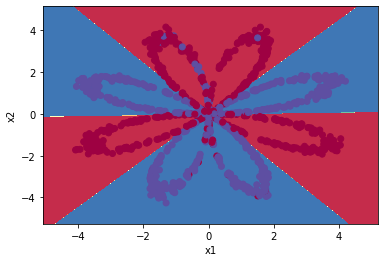

In [162]:
print("Decision Boundary for train, hidden layer size " + str(model.params['w1'].shape[0]))
plot_decision_boundary(lambda x: model(x)>0.5, X_train, y_train)

Decision Boundary for test, hidden layer size 3


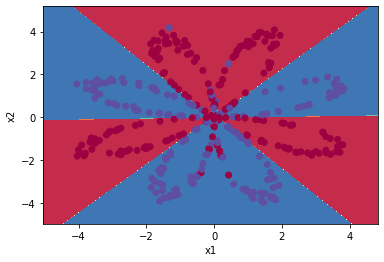

In [163]:
print("Decision Boundary for test, hidden layer size " + str(model.params['w1'].shape[0]))
plot_decision_boundary(lambda x: model(x)>0.5, X_test, y_test)


Построим графики функций потерь для тренировочной и тестовой выборок.

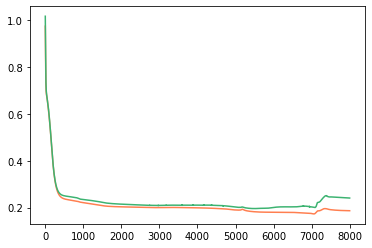

In [164]:
epoches_list = [epocha for epocha in range(1, num_epochs + 1)]
plt.plot(epoches_list, loss_train, 'coral', epoches_list, loss_val, 'mediumseagreen')

Видим, что, начиная примерно с 5500 эпохи, графики начинают расходиться, так как начинается переобучение.
